In [1]:
import platform
import warnings
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from matplotlib import rc
from gensim.models import Word2Vec

warnings.filterwarnings(action='ignore')


In [11]:
class check_data():
    def __init__(self,df):
        self.df = df
        self.wiki_model = Word2Vec.load('../ko/ko.bin')
        if platform.system() == 'Windows':
            self.font = 'Malgun Gothic'
        else:
            self.font = 'NanumGothic'
        self.df['효능_Morps'] = self.df['효능'].map(lambda x: self.getMorps(x))
        self.df['효능_NV'] = self.df['효능_Morps'].map(lambda x: self.getNV(x))
        self.df['효능_N'] = self.df['효능_Morps'].map(lambda x: self.getN(x))
  
    def topn(self,n):
        self.df['효능_count_topn_NV']  = self.df['효능_NV'].map(lambda x: self.counter(x,n)) 
        self.df['효능_count_topn_N']  = self.df['효능_N'].map(lambda x: self.counter(x,n)) 

    def result(self,idx, top , dis):
        energy = ['정열', '활기', '기력', '생기', '활발','--']
        recovery = ['낫', '치료', '휴식' ,'극복' , '재활', '--']
        cycle = ['운반', '유지', '조절' , '공급' ,'생명', '--']
        pury = ['진정' , '맑' , '없애' , '깨끗하', '해소', '--']        
        effs_dims_name = ['에너지', '회복', '순환', '정화']
        effs_dims =  [energy, recovery, cycle , pury]
        sNV = self.df['효능'][idx].split(" ")[1:]

        result = []
        for dim in effs_dims:
            ab = []
            for sim_word in dim:
                sub = []
                for word in sNV:
                    try:
                        sub.append(self.wiki_model.wv.similarity(sim_word , word))
                    except:
                        sub.append(0)
                ab.append(sub)
                aab = np.array(ab).flatten().tolist()
            aab = np.array(sorted(aab,reverse=True))[:top].mean()
            result.append(aab)
        
        if dis == True:
            from matplotlib import rc
            plt.rc('font', family=self.font)

            word = self.df.iloc[idx][0]
            std = np.std(result)
            
            plt.figure()
            plt.bar(np.arange(len(result)),result)
            plt.title(f'{word}\'s mapping for top {top} using 유사어')
            plt.xticks(np.arange(len(effs_dims_name)), effs_dims_name)
            plt.yticks(np.arange(0,1.1,0.1))
            plt.show()
#            print(f'{word}s std is {std}' )
        return result
        
    def getMorps(self,sent):
        return Okt().pos(sent , norm=False , stem = True) 

    def getNV(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "
        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Verb' or morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        return s_result
    
    def getN(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "

        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        s_result = np.unique(s_result)
        return s_result

    def counter(self,sents, n):
        return sorted(collections.Counter(sents),reverse=True)[0:n]

    def get_heatmap(self, emotion_idx,figsize):
        energy = ['정열', '활기', '기력', '생기', '활발','--']
        recovery = ['낫', '치료', '휴식' ,'극복' , '재활', '--']
        cycle = ['운반', '유지', '조절' , '공급' ,'생명', '--']
        pury = ['진정' , '맑' , '없애' , '깨끗하', '해소', '--']        
        effs_dims_name = ['에너지', '회복', '순환', '정화']
        all_dims = energy + recovery + cycle + pury
        
        plt.rc('font', family=self.font)
        sents = self.df['효능'][emotion_idx]
        
        result = []
        spl_sents = sents.split(" ")[1:]
        for word in spl_sents:
            sub = []
            for dim_word in all_dims:
                try:
                    sub.append(self.wiki_model.wv.similarity(dim_word , word))
                except:
                    sub.append(0)
            result.append(sub)

        fig = plt.figure(figsize=figsize)
        fig.set_facecolor('white')
        em_name = self.df['감정'][emotion_idx]
        plt.title(f'{em_name}에서 단어들간의 유사도 확인')
        sns.heatmap(result,annot=True)
        plt.xticks(np.arange(len(all_dims)),all_dims)
        plt.yticks(np.arange(len(spl_sents)),spl_sents)
        plt.show()
              
    def todf(self, topn, file_name):
        ret_df  = pd.DataFrame(columns=['감정','에너지','회복','순환','정화'])
        em = []
        est_e= []
        est_h= []
        est_c= []
        est_p= []
        
        for idx in self.df.index:
            em.append(self.df['감정'][idx])
            est = self.result(idx,topn,False)
            est_e.append(est[0])        
            est_h.append(est[1])        
            est_c.append(est[2])        
            est_p.append(est[3])
        ret_df['감정'] = em        
        ret_df['에너지'] = est_e
        ret_df['회복'] = est_h
        ret_df['순환'] = est_c
        ret_df['정화'] = est_p
        
        ret_df.to_csv(file_name,index=False)
        return ret_df

In [12]:
# 감정 데이터 확인
em_data = pd.read_csv("../data/emotion_data_hand_craft.csv")
em_data

,감정,효능
0,행복,향유 낙관적 느낌 생각 즐기
1,우울,행동 도움 생활 치료 명상
2,슬픔,사랑 도움 가족 시간 활동
3,열정,상기 집중 노력 몰입 휴식
4,분노,정지 회피 긍정 마음 호흡
5,두려움,직면 변화 대화 집중 용기


# 수치화 방법
각 차원에 유사어 대해서 모든 감정 키워드과 유사도 측정 후  
각 차원의 list에서 상위 3개에 대한 평균을 추정치로 사용
* 추후 latex을 이용해서 수식화

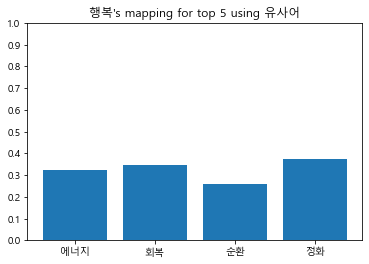

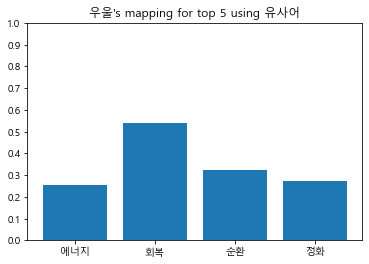

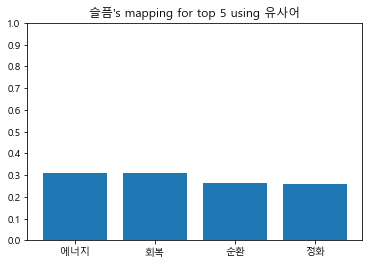

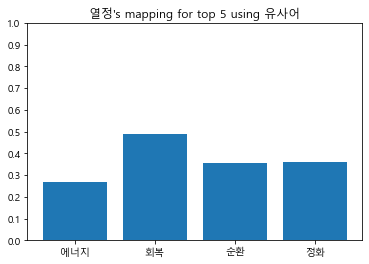

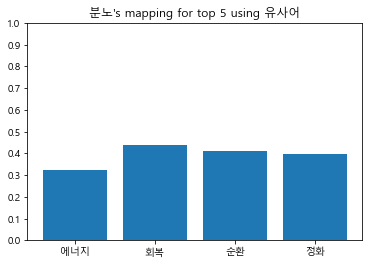

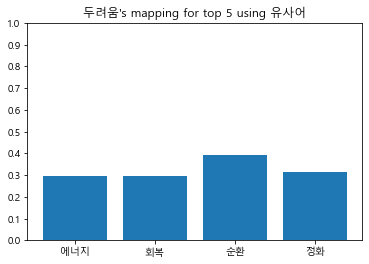

In [13]:
hXYZ = check_data(em_data)
for i in em_data.index:
    #hXYZ.get_heatmap(i, (20,4))
    hXYZ.result(i,5,True)

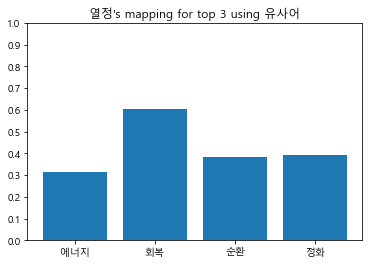

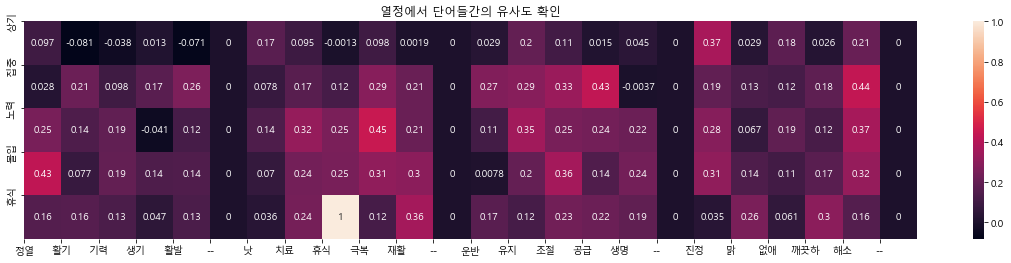

In [14]:
hXYZ.result(3,3,True)
hXYZ.get_heatmap(3, (20,4))

In [15]:
hXYZ.todf(5,'../result/action_estimation.csv')

,감정,에너지,회복,순환,정화
0,행복,0.324557,0.344684,0.257535,0.372669
1,우울,0.256301,0.539817,0.321080,0.273804
2,슬픔,0.310976,0.308342,0.262105,0.256712
3,열정,0.269738,0.488793,0.353732,0.360805
4,분노,0.322202,0.440319,0.408658,0.398532
5,두려움,0.295698,0.295809,0.393288,0.315617
